In [1]:
#Getting the Dataset
if 'google.colab' in str(get_ipython()):
  !wget https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz

--2022-06-28 20:10:45--  https://gitlab.cern.ch/clcheng/gsoc2021_qml/-/raw/master/data/QIS_EXAM_200Events.npz
Resolving gitlab.cern.ch (gitlab.cern.ch)... 188.184.30.144, 188.185.68.13, 188.184.30.115, ...
Connecting to gitlab.cern.ch (gitlab.cern.ch)|188.184.30.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140 (8.9K) [application/zip]
Saving to: ‘QIS_EXAM_200Events.npz’

QIS_EXAM_200Events. 100%[===================>]   8.93K  --.-KB/s    in 0s      

2022-06-28 20:10:46 (183 MB/s) - ‘QIS_EXAM_200Events.npz’ saved [9140/9140]



In [18]:
import numpy as np
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn,randint
!pip install tensorflow
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Conv2D, Conv2DTranspose, Concatenate
from keras.layers import LeakyReLU, Dropout, Embedding
from keras.layers import BatchNormalization, Activation
from keras import initializers
from keras.initializers import RandomNormal
# from tf.keras.optimizers import Adam, RMSprop, SGD
import matplotlib.pyplot as plt
from math import sqrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
data = dict(np.load('QIS_EXAM_200Events.npz',allow_pickle=True))

In [13]:
x_train_bkg = data['training_input'].item()['0']
x_test_bkg = data['test_input'].item()['0']
x_train_sig = data['training_input'].item()['1']
x_test_sig = data['test_input'].item()['1']
# combine the signal and background samples
x_train = np.concatenate((x_train_sig, x_train_bkg))
y_train = np.concatenate((np.ones(x_train_sig.shape[0]), np.zeros(x_train_bkg.shape[0])))
x_test = np.concatenate((x_test_sig, x_test_bkg))
y_test = np.concatenate((np.ones(x_test_sig.shape[0]), np.zeros(x_test_bkg.shape[0])))

In [14]:
n_qubit = x_train.shape[1]
n_qubit

5

In [15]:
print('Signal event shape: ', x_train_sig.shape)
print('Background event shape: ', x_train_bkg.shape)

Signal event shape:  (50, 5)
Background event shape:  (50, 5)


In [16]:
# Plot variable distributions for input
def make_plots(data, labels, binning=20, columns=3):
    X = [d.T for d in data]
    fig=plt.figure(figsize=(20, 10))
    rows =  1 + (X[0].shape[0] // columns)
    bins = np.histogram(np.hstack(tuple(X)), bins=binning)[1]
    plt.subplots_adjust(hspace=0.3)
    for i in range(X[0].shape[0]):
        ax = fig.add_subplot(rows, columns, i+1)
        ax.set_title('Variable {}'.format(i+1), fontsize=15)
        for j, x in enumerate(X):
            ax.hist(x[i], bins=bins, alpha=.5, label=labels[j])
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.2), ncol=len(data), fontsize=10)
    plt.show()

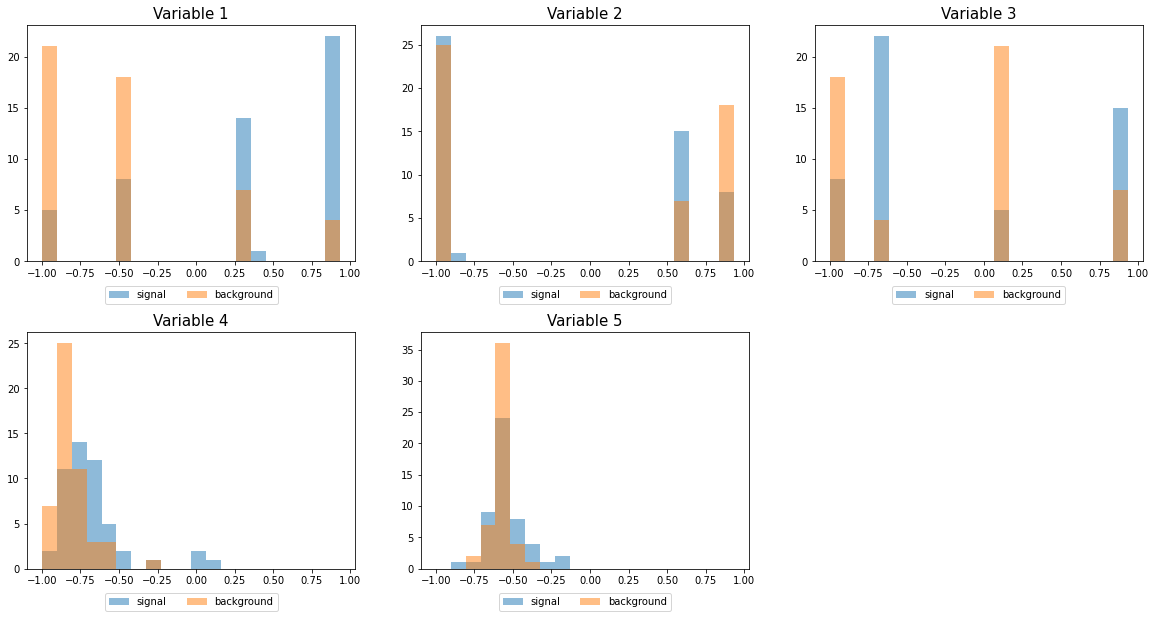

In [19]:
make_plots([x_train_sig, x_train_bkg], ['signal', 'background'])

In [61]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [47]:
# (train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [58]:
train_images = x_train_sig.reshape(x_train_sig.shape[0],5,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [59]:
BUFFER_SIZE = 250
BATCH_SIZE = 100

In [60]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create Models

In [66]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(5, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 5)  # Note: None is the batch size

    return model

In [67]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)



AssertionError: ignored